### Here we are applying matched filter to data from Guiton lab

Three images are provided ()
A - perfectly crystalline
C - some twinning
G - mucho twinning 

#### Procedure

1. Load
2. Draw rectangular box around intact lattice
3. Determine unit cell
4. Stack and mean subtract
5. correlate

However, I'll cut some corners and just attempt to get some rough data without refining the images

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import cv2

root ="/net/share/shared/data/hafnium/"
#root ="./"

In [2]:
def myplot(img,fileName=None):
    plt.axis('equal')
    pcolormesh(img, cmap='gray')
    if fileName!=None:
        plt.gcf().savefig(fileName,dpi=300)

In [4]:
fileName=root+"NatComm_Fig3_A.tif"
def ReadImg(fileName):
    img = cv2.imread(fileName)
    if img is None:
        raise RuntimeError(fileName+" likely doesn't exist")

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return gray


ref= ReadImg(fileName)
myplot(ref)    
    


NameError: name 'root' is not defined

Using gimp, I found a unit cell spanning (532,482)-> (552,510)
Gimp is 'inverted' relative to ndarray convention

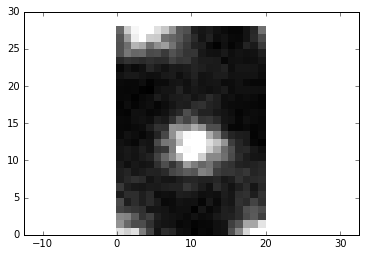

In [4]:
# This function is here to remind me that the axes are transposed in ndarray relative to pcolormesh
def GetSubsection(
  img,
  gimpCoords = np.array( [[532,482],[552,510]])):
  # [y,x]
  unitCell = img[gimpCoords[0,1]:gimpCoords[1,1],gimpCoords[0,0]:gimpCoords[1,0]]
  return unitCell

gimpCoords = np.array( [[532,482],[552,510]])
unitCell = GetSubsection(ref,gimpCoords=gimpCoords)
myplot(unitCell)

#### Test matched filter against 'perfect' crystal

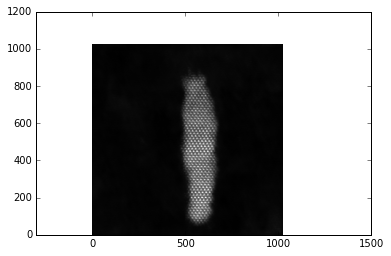

In [5]:
import matchedFilter as mF
href = mF.matchedFilter(ref,unitCell)
myplot(href)
plt.gcf().savefig("ref.png",dpi=300)

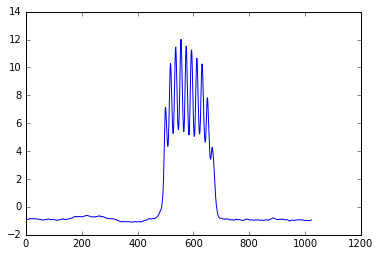

In [6]:
profile = href[600:605,]
profile = np.sum(profile,axis=0)
plt.plot(profile)


#### Test matched filter against perfect crystal with a 'simulated' twinned crystal region

Centered at 583,477

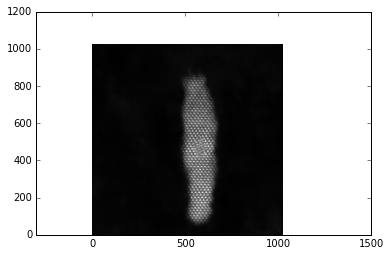

In [8]:
fileName=root+"NatComm_Fig3_Arot.tif"
test= ReadImg(fileName)
htest = mF.matchedFilter(test,unitCell,parsevals=True)
myplot(htest)
plt.gcf().savefig("test.png",dpi=300)

In [9]:

def SimpleDetect(
  ref,  # reference image
  test, # test image 
  xloc=425, # where 'defects' are apparent
  w=5,
  title=None
):

    profile = ref[xloc:(xloc+w),]
    profileRef = np.sum(profile,axis=0)
    print "Ref ", np.sum(profileRef[500:700])

    profile = test[xloc:(xloc+w),]
    profileTest = np.sum(profile,axis=0)
    print "Test ", np.sum(profileTest[500:700])

    plt.plot(profileRef, label="ref")
    plt.plot(profileTest, label="other")
    plt.xlim([500,700])
    plt.legend()

    if title!=None:
        plt.title(title)
        
    print "Error %f"%( np.sum((profileRef-profileTest)**2) )


Ref  1151.95349902
Test  1162.86159123
Error 219.633165


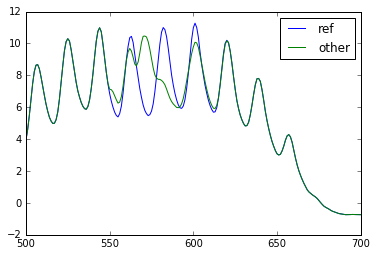

In [10]:
SimpleDetect(href,htest)

#### How does it compare to eyeball (unfiltered?) 
Just as well/if not better. Under what conditions would match filter be better to use

Ref  68191
Test  69896
Error 3519235.000000


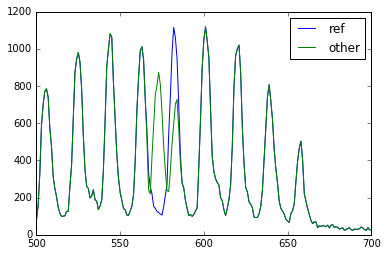

In [11]:
SimpleDetect(ref,test)

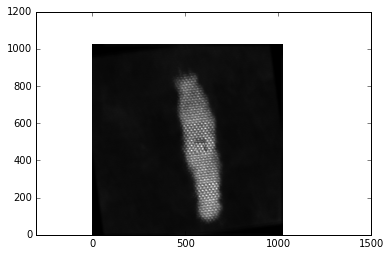

In [12]:
fileName=root+"NatComm_Fig3_Arot2.tif"
test2= ReadImg(fileName)
htest2 = mF.matchedFilter(test2,unitCell,parsevals=True)
myplot(htest2)
plt.gcf().savefig("test2.png",dpi=300)

Ref  1162.86159123
Test  1342.92408227
Error 1513.010063


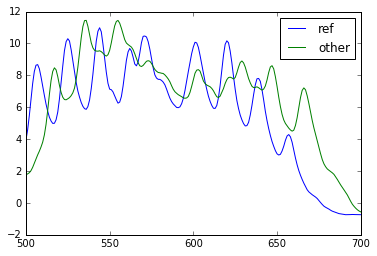

In [13]:
SimpleDetect(htest,htest2)

#### Add buncho noise

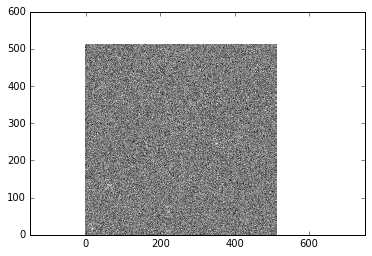

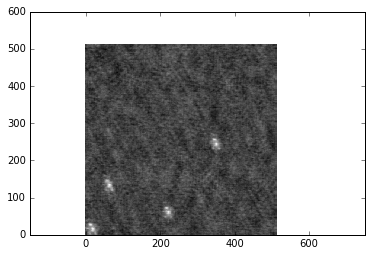

In [14]:
noise = np.reshape( np.random.randn( 512*512 ), [512,512])
noise += 128
noise *= 100

# a few spots 
measured = noise+0.
cellDim = np.shape(unitCell)
i=5;j=10
measured[i:(i+cellDim[0]),j:(j+cellDim[1])] += unitCell
i=50;j=213
measured[i:(i+cellDim[0]),j:(j+cellDim[1])] += unitCell
i=123;j=54
measured[i:(i+cellDim[0]),j:(j+cellDim[1])] += unitCell
i=234;j=342
measured[i:(i+cellDim[0]),j:(j+cellDim[1])] += unitCell


myplot(measured)
htest_ = mF.matchedFilter(measured,unitCell,parsevals=True)
plt.figure()
myplot(htest_)
#plt.gcf().savefig("test2.png",dpi=300)

print np.min(unitCell)

### Generate faux images that resemble polymorphic crystals in Beth's data 

#### noise free

In [3]:
import genimage as gi


(386, 2)
(512, 512)


/home/AD/pmke226/.local/lib/python2.7/site-packages/numpy/core/fromnumeric.py:48: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  result = getattr(asarray(obj), method)(*args, **kwds)


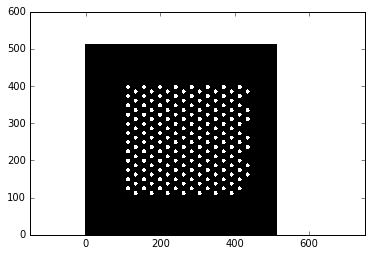

In [4]:
perfect = gi.GenLattice(mode="perfect")
myplot(perfect,fileName="perfect.png")


(348, 2)
(512, 512)


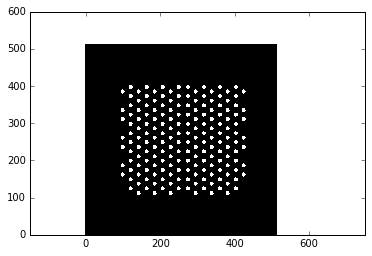

In [5]:


twinned = gi.GenLattice(mode="twinned")
myplot(twinned)

#### Add noise 

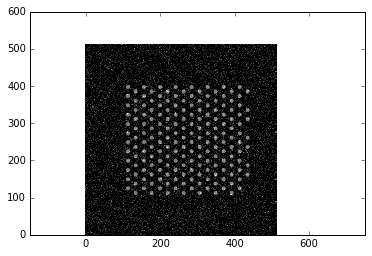

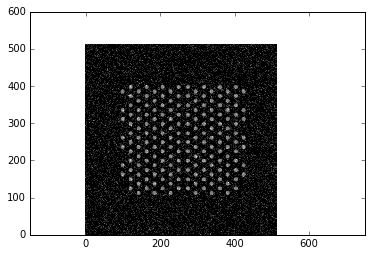

In [110]:
realPerfect = gi.AddRealism(perfect)
myplot(realPerfect)

plt.figure()
realTwinned = gi.AddRealism(twinned)
myplot(realTwinned)


#### Grab unit cells for matched filter 

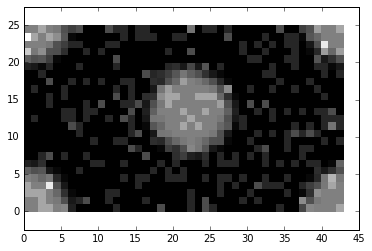

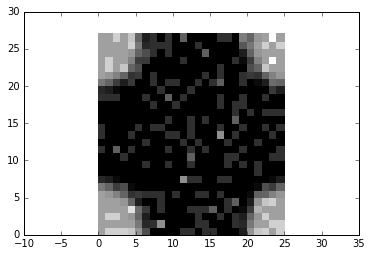

In [111]:

#subset = realTwinned[150:550,162:206]
unitCellXtal = realTwinned[150:175,164:207]
myplot(unitCellXtal)

plt.figure()
unitCellInterface = realTwinned[125:152,250:275]
myplot(unitCellInterface)

#### Test filters on simulated data (adding noise fllor)

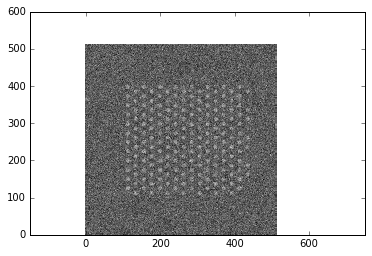

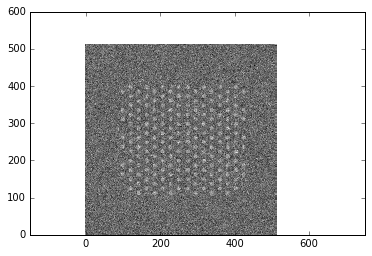

In [113]:
realPerfect = gi.AddRealism(perfect,noiseFloor=True)
myplot(realPerfect)

plt.figure()
realTwinned = gi.AddRealism(twinned,noiseFloor=True)
myplot(realTwinned)

In [114]:
def mytriplot(img,h1,h2):
    plt.subplot(231)
    plt.axis('equal')
    plt.pcolormesh(img,cmap='gray')
    plt.title("Raw")
    plt.axis('off')
    
    plt.subplot(232)
    plt.axis('equal')
    plt.pcolormesh(h1,cmap='gray')
    plt.title("Filter Xtal")
    plt.axis('off')
    
    plt.subplot(233)
    plt.axis('equal')
    plt.pcolormesh(h2,cmap='gray')
    plt.title("Filter Interface")
    plt.axis('off')

    plt.tight_layout()




##### Perfect data 

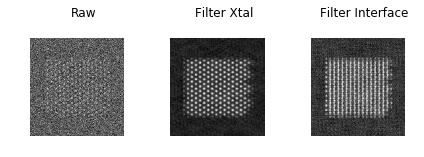

In [120]:
import matchedFilter as mF

hXtal = mF.matchedFilter(realPerfect,unitCellXtal)
hInter = mF.matchedFilter(realPerfect,unitCellInterface)

mytriplot(realPerfect,hXtal,hInter)
plt.gcf().savefig("perfect.png",dpi=300)


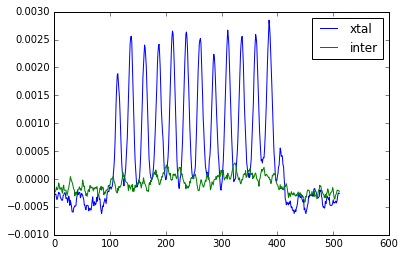

In [116]:
#plt.pcolormesh(hInter)
#plt.figure()
test1 = np.sum(hXtal[:,260:265],axis=1)
test2 = np.sum(hInter[:,260:265],axis=1)

plt.plot(test1,label="xtal")
plt.plot(test2,label="inter")
plt.legend()


##### Craptastic data

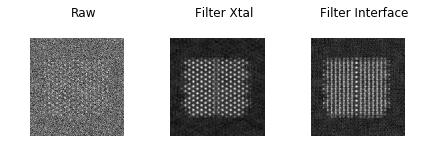

In [117]:
hXtal = mF.matchedFilter(realTwinned,unitCellXtal)
hInter = mF.matchedFilter(realTwinned,unitCellInterface)

mytriplot(realTwinned,hXtal,hInter)
plt.gcf().savefig("real.png",dpi=300)

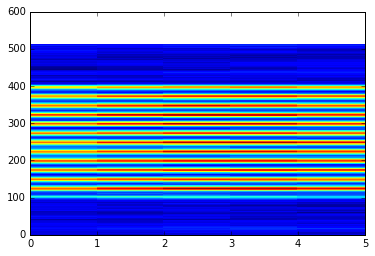

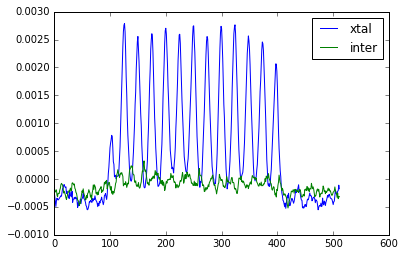

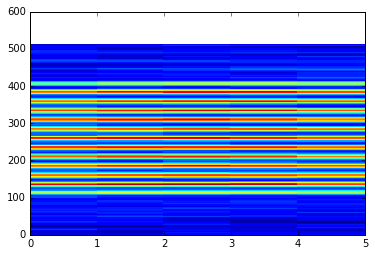

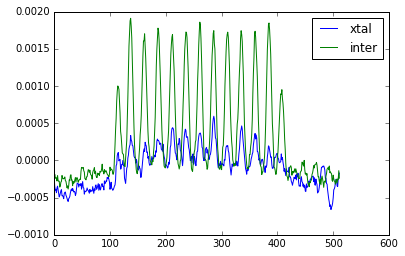

In [118]:
# approximately where hXtal is maximal 
plt.pcolormesh(hXtal[:,315:320])
test1 = np.sum(hXtal[:,315:320],axis=1)
test2 = np.sum(hInter[:,315:320],axis=1)

plt.figure()
plt.plot(test1,label="xtal")
plt.plot(test2,label="inter")
plt.legend()


# approximately where hInter is maximal 
plt.figure()
plt.pcolormesh(hInter[:,260:265])

test1 = np.sum(hXtal[:,260:265],axis=1)
test2 = np.sum(hInter[:,260:265],axis=1)

plt.figure()
plt.plot(test1,label="xtal")
plt.plot(test2,label="inter")
plt.legend()
